In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:


#using pandas, load the dataset in data frame form 
df = pd.read_csv("data.csv")

#some info about the dataset
df.info()


#brief check for missing values - there are none
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [3]:
#isolate our response value (named Bankrupt?)
X = df.drop(columns=['Bankrupt?'])  #predictors, every variable that is not the response 
y = df['Bankrupt?']  #response variable 


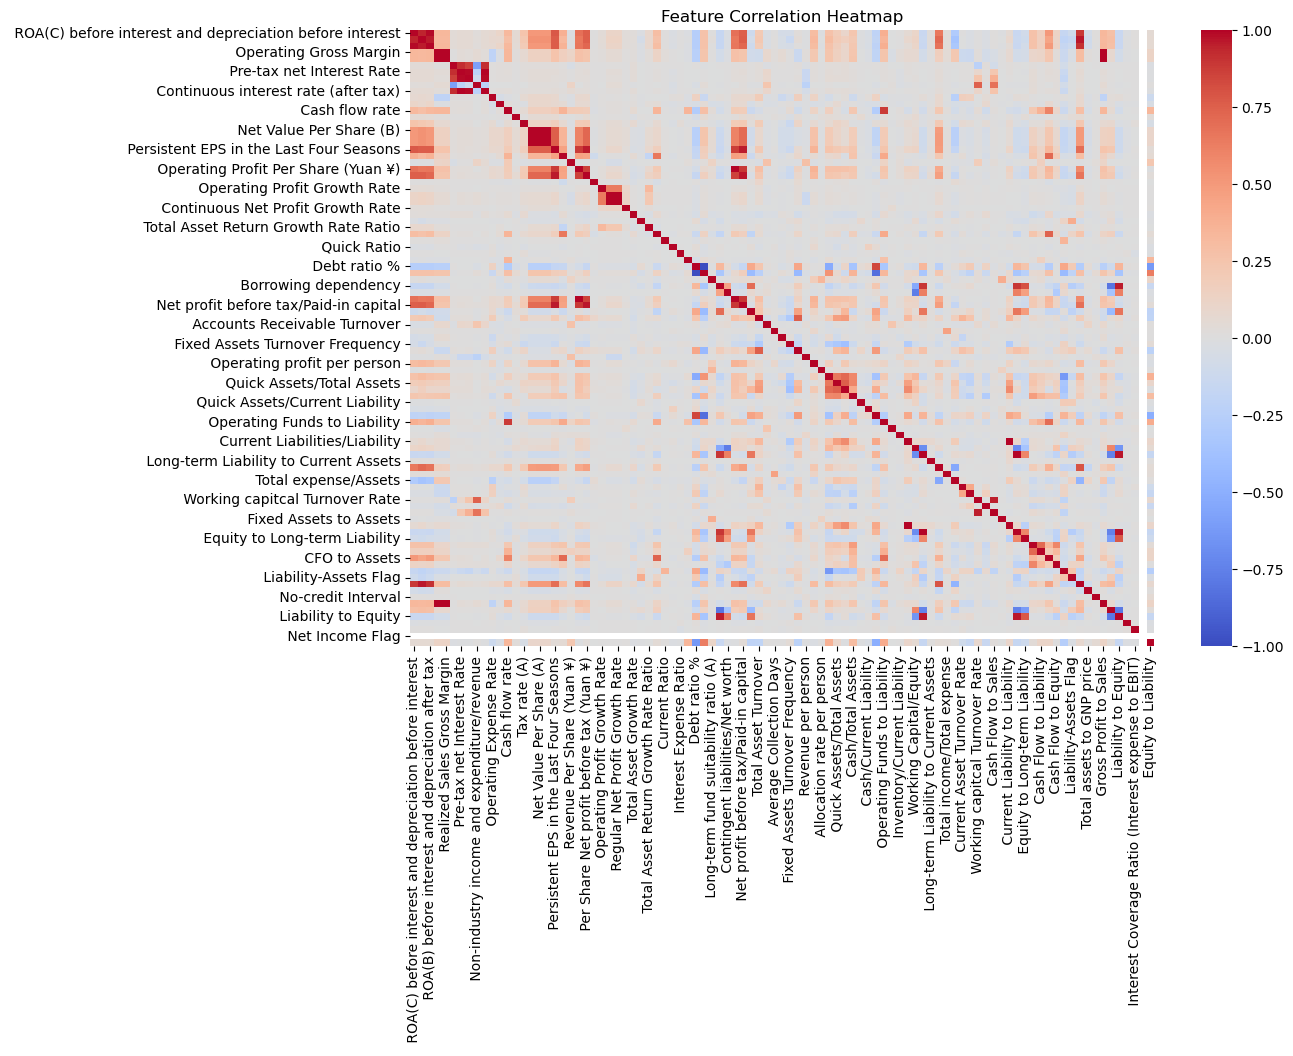

In [4]:
#create a scaler and use it to standardize the predictors 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#check for multicollinearity using correlation matrix
correlation_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

#very clear evidence of multicollinearity - do not handle for now 

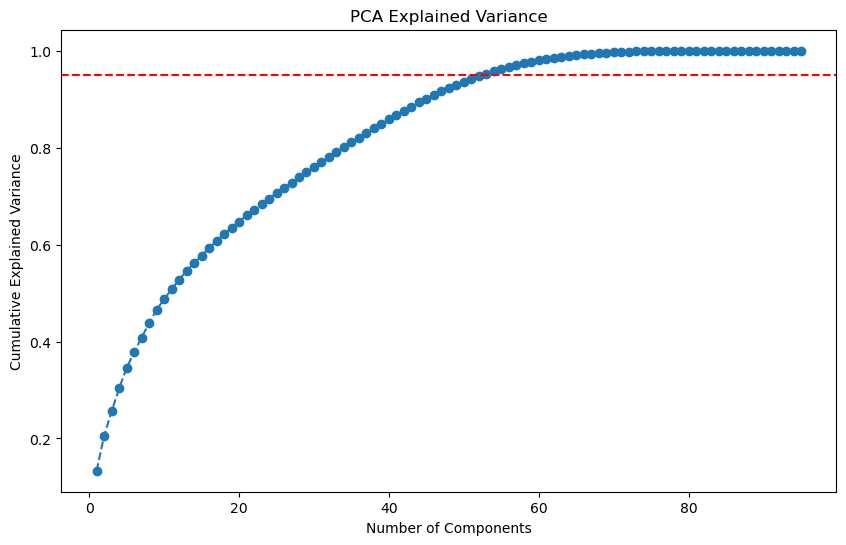

In [5]:
#apply PCA to reduce dimensionality
pca = PCA()
X_pca = pca.fit_transform(X_scaled)



#setermine the number of principal components to keep (explained variance)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.axhline(y=0.95, color='r', linestyle='--')  #will represent the 95% threshold
plt.show()


In [6]:

#selecting the optimal number of principal components
n_components = np.argmax(explained_variance_ratio >= 0.95) + 1  #min components for 95% variance
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled) #reduced predictors

print(n_components) #result is 53 components/predictors 

53


In [7]:
#lasso regression with REDUCED PREDICTORS

#split PCA-reduced data - 80/20 split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

#train Lasso on PCA-transformed data, use 5 CV
lasso_pca = LassoCV(cv=5, random_state=42).fit(X_train_pca, y_train)

#predict and find accuracy score
y_pred_pca = np.where(lasso_pca.predict(X_test_pca) > 0.5, 1, 0)
print("Lasso Regression Accuracy with PCA:", accuracy_score(y_test, y_pred_pca)) #same accuracy score as below


Lasso Regression Accuracy with PCA: 0.9626099706744868


In [8]:

#lasso regression
#split data into testing and training sets (80/20 split) - note the use of X_scaled again, our standardized predictors
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#apply Lasso Regression with cross-validation to select important features, select best alpha value 
#model will automatically remove unimportant predictors, setting their coefficients to zero
#5 cross fold validation used to optimize hyperparameters
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

#display selected features (non-zero coefficients) - think of as the 'best' variables to use?
selected_features = X.columns[lasso.coef_ != 0]
print("Selected Features by Lasso Regression:", selected_features)

#evaluate the performance of Lasso on the test set
y_pred = lasso.predict(X_test) #predictions on y using X test data
y_pred = np.where(y_pred > 0.5, 1, 0)  #convert continuous output to binary (any prob greater than 0.5 goes to 1)
print("Lasso Regression Accuracy:", accuracy_score(y_test, y_pred)) #accuracy score of 0.96


C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03894553818122404, tolerance: 0.013082378551787347
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052545655670016345, tolerance: 0.013082378551787347
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05472146568979497, tolerance: 0.013082378551787347
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

Selected Features by Lasso Regression: Index([' Tax rate (A)', ' Debt ratio %', ' Net worth/Assets',
       ' Borrowing dependency', ' Fixed Assets Turnover Frequency',
       ' Net Worth Turnover Rate (times)', ' Revenue per person',
       ' Cash/Current Liability', ' Operating Funds to Liability',
       ' Working Capital/Equity', ' Total expense/Assets',
       ' Cash Turnover Rate', ' Cash Flow to Equity',
       ' Current Liability to Current Assets', ' Liability-Assets Flag',
       ' Net Income to Total Assets'],
      dtype='object')
Lasso Regression Accuracy: 0.9626099706744868


C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019770580561612405, tolerance: 0.012800733272227308
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032796221958975025, tolerance: 0.012800733272227308
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09856147122658854, tolerance: 0.012800733272227308
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

In [9]:
#after PCA, apply lasso for even fewer predictors
pca_fewer = PCA(n_components=30)
X_pca_fewer = pca_fewer.fit_transform(X_scaled)

#train Lasso with 30 components
X_train_fewer, X_test_fewer, y_train, y_test = train_test_split(X_pca_fewer, y, test_size=0.2, random_state=42)
lasso_fewer = LassoCV(cv=5, random_state=42, max_iter=5000).fit(X_train_fewer, y_train)
y_pred_fewer = np.where(lasso_fewer.predict(X_test_fewer) > 0.5, 1, 0)

print("Lasso Regression Accuracy with 30 Components:", accuracy_score(y_test, y_pred_fewer)) #accuracy of 0.9633 - about same


Lasso Regression Accuracy with 30 Components: 0.9626099706744868


In [10]:
#Conclusion/Stuff did:
# 1. PCA was used to reduce dimensionality while preserving 95% variance.
# 2. Lasso regression was applied to identify the most important features.
# 3. The selected features from Lasso provide a reduced, optimized dataset for prediction.
# 4. Reduced the model with pca and lasso even further

#Seems that PCA/Lasso give the same accuracy, as does lasso on the reduced and original model, indicating that PCA is not
#very helpful - PCA is not significantly affecting/changing the feature space in a way that affects - this could mean a few things:

#PCA retains nearly all the important information - lasso works with the same underlying important data with PCA and the 
#original model, indicating that Lasso is working effectively, without much help from PCA, it already optimal and able to
#remove redundant information.  Perhaps the data just lacks noise and is very linearly seperable, explaining Lasso's 
#good performance.  

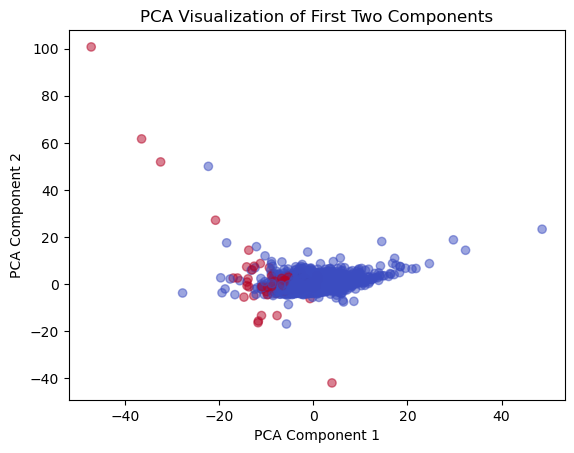

In [11]:


plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y, cmap="coolwarm", alpha=0.5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of First Two Components")
plt.show()


In [12]:
#From this visual, if we had seen that the points are very clearly seperable, than this would provide evidence that lasso did
#not need PCA to perform well on the data.  Looking at the visual, it's a bit hard to tell, but there are a number of points
#that seem easy to differentiate.

In [13]:
#PCA with fewer and fewer components

# Define a range of PCA components to test (from 30 down to 5, decreasing by 5)
component_range = range(30, 0, -5)
accuracy_scores = []

for n_components in component_range:
    #Apply PCA with n_components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    
    lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
    
    y_pred = np.where(lasso.predict(X_test) > 0.5, 1, 0)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append((n_components, accuracy))
    
    print(f"Lasso Regression Accuracy with {n_components} Components: {accuracy:.4f}")

# Convert to numpy array for easier plotting
accuracy_scores = np.array(accuracy_scores)



Lasso Regression Accuracy with 30 Components: 0.9626
Lasso Regression Accuracy with 25 Components: 0.9626
Lasso Regression Accuracy with 20 Components: 0.9633
Lasso Regression Accuracy with 15 Components: 0.9626
Lasso Regression Accuracy with 10 Components: 0.9626
Lasso Regression Accuracy with 5 Components: 0.9626


In [14]:
#This result is intriguing.  Even with just five components, accuracy remains high, suggesting that a small subset of the 
#predictors hold the vast majority of the predictive power, or that again, lasso already works quite well with the data, and
#PCA provides little benefit.  Again, the data could also just be very linearly separable and reducing dimensions does not
#impact accuracy.  It is also worth mentioning that lasso regression does not suffer from higher dimensions like other models
#explaining why PCA might have such little effect.

In [15]:
for n in range(30, 0, -5):
    pca = PCA(n_components=n)
    pca.fit(X_scaled)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"PCA Components: {n}, Variance Retained: {explained_variance:.4f}")


PCA Components: 30, Variance Retained: 0.7582
PCA Components: 25, Variance Retained: 0.7041
PCA Components: 20, Variance Retained: 0.6463
PCA Components: 15, Variance Retained: 0.5767
PCA Components: 10, Variance Retained: 0.4870
PCA Components: 5, Variance Retained: 0.3456


In [16]:
#From the above results, we see that even as lasso accuracy remains fairly consistent, the total variance retained decreases
#as we reduce the number of PCA components.  A few explanations hold: the remaining variance still contains the most predictive
#features, so that even though the variance is decreasing, the PCA components that remain still hold the most important features
#for classification - if our lasso is working with the right subset of features, losing additional variance should not affect
#the classifications.  Another reason could be that lasso is learning the same decision boundary, finding the same relationships
#between features and the target variable regardless of the amount of PCA components, suggesting once more that the most 
#important information is concentrated in the first few principle components, with additional variance not adding predtictive 
#power.  

#Other notes worth mentioning:

#Variance and predictive power are not the same thing.  PCA maximizes variance, but not necessarily classification accuracy.
#Even if a dataset retains 35% variance (as shown with 5 PCA components), that does not indicate that 65% of the predictive power
#is lost, rather it means that the resulting components are less variable.  

#The results could indicate, as we've speculated several times already, that redundant features were removed.  If the PCA 
#transformation removed mostly redundant information, than Lasso was already ignoring those redundant features, leading to the
#same classification accuracy.

#Once more, we might conclude that the dataset is relatively easy to classify.  If our dataset is not too noisy and the classes
#are already well separated, than PCA does not significantly change how well Lasso can differentiate between them. 

In [17]:
#moving on to another model to test PCA performance.  We will look at a non-linear model

from sklearn.ensemble import RandomForestClassifier

for n in range(30, 0, -5):
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    print(f"Random Forest Accuracy with {n} Components: {accuracy_score(y_test, y_pred_rf):.4f}")


Random Forest Accuracy with 30 Components: 0.9633
Random Forest Accuracy with 25 Components: 0.9655
Random Forest Accuracy with 20 Components: 0.9641
Random Forest Accuracy with 15 Components: 0.9641
Random Forest Accuracy with 10 Components: 0.9648
Random Forest Accuracy with 5 Components: 0.9670


In [18]:
#Accuracy seems to actually increase with random forests, so perhaps this is a better way forward for this data.  However, the
#high accuracy indicates that PCA isn't necessarily removing useful information, but rather redundant information, matching our
#suspicions from earlier.

In [19]:
for n in range(30, 0, -5):
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    lasso = LassoCV(cv=5, random_state=42, max_iter=5000).fit(X_train, y_train)
    num_features = np.sum(lasso.coef_ != 0)

    print(f"PCA Components: {n}, Lasso Selected Features: {num_features}")


PCA Components: 30, Lasso Selected Features: 10
PCA Components: 25, Lasso Selected Features: 15
PCA Components: 20, Lasso Selected Features: 10
PCA Components: 15, Lasso Selected Features: 10
PCA Components: 10, Lasso Selected Features: 7
PCA Components: 5, Lasso Selected Features: 2


In [20]:
#It seems that lasso does NOT select the same amount of information despite differing PCA components, indicating that PCA may 
#have some role here - seems to contradict earlier findings/suspicions.

In [21]:
#These results, overall, indicate that reducing the amount of components has little effect on the accuracy of the random forest
#and lasso models, even if the lasso selected feature amount decreases along with PCA components.  

#The random forests example illustrates once more that the first few components seem to hold the vast majority of the predictive 
#power, thus random forests can still extract enough relevant features even with fewer PCA components.  If variance loss was
#a problem we would likely see a clear accuracy drop with fewer PCA components, but this did not happen.

#Looking at the lasso example, the number of selected features decreases along with the number of PCA components.  With 5 PCA
#components, Lasso selects only 2 features, meaning it has very little information to work with.  At 20 PCA components, Lasso
#selects 17 features, which is the highest amount (accuracy still remains unchanged however).  This suggests that Lasso is still
#finding enough key features for classification, even when PCA removes some features.  Overall, lasso is selecting fewer features
#with lower PCA components, but this does not significantly impact accuracy, once again indicating that the first few PCA
#components contain the most important predictive features, making additional ones redundant.  


#Looking at all of this, it seems that PCA is not harming classification accuracy, so reducing dimensions is fine (which is
#of course preferable).  However, since accuracy does not improve either, PCA may not be necessary for these models.  Most of
#the information is in the first few PCA components, meaning that models can still learn effectively even with a lower-dimensional
#dataset.  

In [22]:
#running PCA with 2 components, random forests model
pca_fewest = PCA(n_components=2)
X_pca_fewest = pca_fewest.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca_fewest, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy with 2 Components:", accuracy_score(y_test, y_pred_rf))


Random Forest Accuracy with 2 Components: 0.9626099706744868


In [23]:
# See which original features contribute most to the available PCA components
pca_components_df = pd.DataFrame(pca_fewest.components_, columns=X.columns)

# Adjust loop to iterate only through the available principal components
for i in range(pca_fewest.n_components_):  # Ensures no out-of-bounds error
    print(f"Top features for Principal Component {i+1}:")
    print(pca_components_df.iloc[i].abs().sort_values(ascending=False).head(5))
    print()


Top features for Principal Component 1:
 ROA(A) before interest and % after tax                     0.239805
 Persistent EPS in the Last Four Seasons                    0.239479
 ROA(C) before interest and depreciation before interest    0.238807
 ROA(B) before interest and depreciation after tax          0.236934
 Net profit before tax/Paid-in capital                      0.234156
Name: 0, dtype: float64

Top features for Principal Component 2:
 Current Liability to Equity                    0.319393
 Current Liabilities/Equity                     0.319393
 Liability to Equity                            0.317403
 Borrowing dependency                           0.289457
 Inventory and accounts receivable/Net value    0.263034
Name: 1, dtype: float64



In [24]:
#testing first few components in a non-linear setting - SVMs
from sklearn.svm import SVC

X_pca_2 = PCA(n_components=2).fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_pca_2, y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print(f"SVM Accuracy with 2 PCA Components: {accuracy_score(y_test, y_pred_svm):.4f}")


SVM Accuracy with 2 PCA Components: 0.9626


In [25]:
#accuracy seems about similar, indicating that this dataset is just likely very suitable for classification

In [26]:
#lasso selected features, uses just the standardized predictors
#lasso regression
#split data into testing and training sets (80/20 split) - note the use of X_scaled again, our standardized predictors
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#apply Lasso Regression with cross-validation to select important features, select best alpha value 
#model will automatically remove unimportant predictors, setting their coefficients to zero
#5 cross fold validation used to optimize hyperparameters
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

#display selected features (non-zero coefficients) - think of as the 'best' variables to use?
selected_features = X.columns[lasso.coef_ != 0]
print("Selected Features by Lasso Regression:", selected_features)

C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03894553818122404, tolerance: 0.013082378551787347
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052545655670016345, tolerance: 0.013082378551787347
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05472146568979497, tolerance: 0.013082378551787347
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

Selected Features by Lasso Regression: Index([' Tax rate (A)', ' Debt ratio %', ' Net worth/Assets',
       ' Borrowing dependency', ' Fixed Assets Turnover Frequency',
       ' Net Worth Turnover Rate (times)', ' Revenue per person',
       ' Cash/Current Liability', ' Operating Funds to Liability',
       ' Working Capital/Equity', ' Total expense/Assets',
       ' Cash Turnover Rate', ' Cash Flow to Equity',
       ' Current Liability to Current Assets', ' Liability-Assets Flag',
       ' Net Income to Total Assets'],
      dtype='object')


C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5197350611167053, tolerance: 0.012800733272227308
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.471400790542802, tolerance: 0.012800733272227308
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\rowan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3210884936997758, tolerance: 0.012800733272227308
  model = cd_fast.enet_coordinate_descent_gram(


In [27]:
#Selected features with lasso on standardized data: ' Tax rate (A)', ' Debt ratio %', ' Net worth/Assets',
#       ' Borrowing dependency', ' Fixed Assets Turnover Frequency',
#      ' Net Worth Turnover Rate (times)', ' Revenue per person',
#       ' Cash/Current Liability', ' Operating Funds to Liability',
#       ' Working Capital/Equity', ' Total expense/Assets',
#       ' Cash Turnover Rate', ' Cash Flow to Equity',
#       ' Current Liability to Current Assets', ' Liability-Assets Flag',
#       ' Net Income to Total Assets'

In [28]:
#Top features for Principal Component 1:
 #ROA(A) before interest and % after tax                     0.239805
 #Persistent EPS in the Last Four Seasons                    0.239479
 #ROA(C) before interest and depreciation before interest    0.238807
 #ROA(B) before interest and depreciation after tax          0.236934
 #Net profit before tax/Paid-in capital                      0.234156


#Top features for Principal Component 2:
 #Current Liability to Equity                    0.319393
 #Current Liabilities/Equity                     0.319393
 #Liability to Equity                            0.317402
 #Borrowing dependency                           0.289456
 #Inventory and accounts receivable/Net value    0.263032



In [29]:
#Lasso regression with feature selection on the standardized predictors selects 16 key features that directly predict
#bakruptcy, with these feautres mostly relating to liquidty, profitability, debt structure, and cash flow

#For PCA (the top 2 principle components), the first two PCA components capture most of the variance, with the first PC 
#emphasizing profitability metrics (ROA, EPS, Net Profit), and the second PC emphasizing leverage and liabilities 
#(debt-to-equity, borrowing dependency).

#The difference between the two selections is that lasso selects individual predictors that optimize accuracy directly, while
#PCA finds the best linear combinations of features that explain the most variance.

#We will move forward with implementing logistic regression models using different predictor sets

Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit Growth Rate'

In [36]:
#Logisitic with lasso-selected features:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#lasso selected features, as shown in an above code chunk
lasso_features = [
    "Tax rate (A)", "Debt ratio %", "Net worth/Assets", "Borrowing dependency",
    "Fixed Assets Turnover Frequency", "Net Worth Turnover Rate (times)", "Revenue per person",
    "Cash/Current Liability", "Operating Funds to Liability", "Working Capital/Equity",
    "Total expense/Assets", "Cash Turnover Rate", "Cash Flow to Equity",
    "Current Liability to Current Assets", "Liability-Assets Flag", "Net Income to Total Assets"
]

#convert the scaled array back to a DataFrame so that we can access specific columns
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

#normalize column names in df using the strip() method, prevents minor inconsistencies from affecting column names
X_scaled_df.columns = X_scaled_df.columns.str.strip()


X_lasso = X_scaled_df[lasso_features]
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.2, random_state=42)


log_reg_lasso = LogisticRegression(max_iter=5000, random_state=42)
log_reg_lasso.fit(X_train, y_train)


y_pred_lasso = log_reg_lasso.predict(X_test)
print("Logistic Regression Accuracy (Lasso Features):", accuracy_score(y_test, y_pred_lasso))


Logistic Regression Accuracy (Lasso Features): 0.9640762463343109


In [37]:
#Logistic Regression with PCA selected features


pca_features = [
    "ROA(A) before interest and % after tax",
    "Persistent EPS in the Last Four Seasons",
    "ROA(C) before interest and depreciation before interest",
    "ROA(B) before interest and depreciation after tax",
    "Net profit before tax/Paid-in capital",
    "Current Liability to Equity",
    "Current Liabilities/Equity",
    "Liability to Equity",
    "Borrowing dependency",
    "Inventory and accounts receivable/Net value"
]


X_pca_features = X_scaled_df[pca_features]
X_train, X_test, y_train, y_test = train_test_split(X_pca_features, y, test_size=0.2, random_state=42)


log_reg_pca_features = LogisticRegression(max_iter=5000, random_state=42)
log_reg_pca_features.fit(X_train, y_train)


y_pred_pca_features = log_reg_pca_features.predict(X_test)
print("Logistic Regression Accuracy (PCA-Selected Features):", accuracy_score(y_test, y_pred_pca_features))


Logistic Regression Accuracy (PCA-Selected Features): 0.9648093841642229


In [38]:
#Hybrid logistic regression with features from both Lasso and PCA

#overlapping features between Lasso and PCA
hybrid_features = list(set(lasso_features) & set(pca_features))


X_hybrid = X_scaled_df[hybrid_features]
X_train, X_test, y_train, y_test = train_test_split(X_hybrid, y, test_size=0.2, random_state=42)


log_reg_hybrid = LogisticRegression(max_iter=5000, random_state=42)
log_reg_hybrid.fit(X_train, y_train)


y_pred_hybrid = log_reg_hybrid.predict(X_test)
print("Logistic Regression Accuracy (Hybrid Features):", accuracy_score(y_test, y_pred_hybrid))


Logistic Regression Accuracy (Hybrid Features): 0.9633431085043989


In [39]:
#Logisiic regression on PCA components (instead of original features)

#apply PCA with 2 components
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)


X_train, X_test, y_train, y_test = train_test_split(X_pca_2, y, test_size=0.2, random_state=42)


log_reg_pca = LogisticRegression(max_iter=5000, random_state=42)
log_reg_pca.fit(X_train, y_train)

y_pred_pca = log_reg_pca.predict(X_test)
print("Logistic Regression Accuracy (PCA Components):", accuracy_score(y_test, y_pred_pca))


Logistic Regression Accuracy (PCA Components): 0.9633431085043989


In [40]:
#For the sake of this project, interpretability is preferable, and since the accuracy scores do not vary a lot, we should go with
#lasso based feature selection.

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd

#define the features once more 
lasso_features = [
    "Tax rate (A)", "Debt ratio %", "Net worth/Assets", "Borrowing dependency",
    "Fixed Assets Turnover Frequency", "Net Worth Turnover Rate (times)", "Revenue per person",
    "Cash/Current Liability", "Operating Funds to Liability", "Working Capital/Equity",
    "Total expense/Assets", "Cash Turnover Rate", "Cash Flow to Equity",
    "Current Liability to Current Assets", "Liability-Assets Flag", "Net Income to Total Assets"
]

pca_features = [
    "ROA(A) before interest and % after tax",
    "Persistent EPS in the Last Four Seasons",
    "ROA(C) before interest and depreciation before interest",
    "ROA(B) before interest and depreciation after tax",
    "Net profit before tax/Paid-in capital",
    "Current Liability to Equity",
    "Current Liabilities/Equity",
    "Liability to Equity",
    "Borrowing dependency",
    "Inventory and accounts receivable/Net value"
]

hybrid_features = list(set(lasso_features) & set(pca_features))

#ensure train-test splits remain consistent across models
X_train_lasso, X_test_lasso, y_train, y_test = train_test_split(X_scaled_df[lasso_features], y, test_size=0.2, random_state=42)
X_train_pca_features, X_test_pca_features, _, _ = train_test_split(X_scaled_df[pca_features], y, test_size=0.2, random_state=42)
X_train_hybrid, X_test_hybrid, _, _ = train_test_split(X_scaled_df[hybrid_features], y, test_size=0.2, random_state=42)

#apply PCA correctly (Fit PCA only on the training set, then transform test set)
pca_2 = PCA(n_components=2)
X_train_pca_2 = pca_2.fit_transform(X_train_lasso)  #fit only on train set
X_test_pca_2 = pca_2.transform(X_test_lasso)  #transform test set

#train logistic regression models
log_reg_lasso = LogisticRegression(max_iter=5000, random_state=42).fit(X_train_lasso, y_train)
log_reg_pca_features = LogisticRegression(max_iter=5000, random_state=42).fit(X_train_pca_features, y_train)
log_reg_hybrid = LogisticRegression(max_iter=5000, random_state=42).fit(X_train_hybrid, y_train)
log_reg_pca = LogisticRegression(max_iter=5000, random_state=42).fit(X_train_pca_2, y_train)

#dictionary mapping models to their respective test sets
models = {
    "Lasso-Selected Features": (log_reg_lasso, X_test_lasso),
    "PCA-Selected Features": (log_reg_pca_features, X_test_pca_features),
    "Hybrid (Lasso ∩ PCA)": (log_reg_hybrid, X_test_hybrid),
    "PCA Components": (log_reg_pca, X_test_pca_2)  #PCA applied correctly
}

#function to evaluate models
def evaluate_model(model, X_test, y_test, model_name, threshold=0.5):#we will change threshold later
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC
    
    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC Score": roc_auc_score(y_test, y_prob)
    }
    
    return metrics


results = []

for model_name, (model, X_test_set) in models.items():
    results.append(evaluate_model(model, X_test_set, y_test, model_name))


results_df = pd.DataFrame(results)

print(results_df)







                     Model  Accuracy  Precision    Recall  F1 Score  \
0  Lasso-Selected Features  0.964076   0.583333  0.137255  0.222222   
1    PCA-Selected Features  0.964809   0.636364  0.137255  0.225806   
2     Hybrid (Lasso ∩ PCA)  0.963343   1.000000  0.019608  0.038462   
3           PCA Components  0.961144   0.416667  0.098039  0.158730   

   ROC-AUC Score  
0       0.918896  
1       0.894255  
2       0.846527  
3       0.894225  


In [46]:
#decrease the decision threshold 

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd

#define the features once more 
lasso_features = [
    "Tax rate (A)", "Debt ratio %", "Net worth/Assets", "Borrowing dependency",
    "Fixed Assets Turnover Frequency", "Net Worth Turnover Rate (times)", "Revenue per person",
    "Cash/Current Liability", "Operating Funds to Liability", "Working Capital/Equity",
    "Total expense/Assets", "Cash Turnover Rate", "Cash Flow to Equity",
    "Current Liability to Current Assets", "Liability-Assets Flag", "Net Income to Total Assets"
]

pca_features = [
    "ROA(A) before interest and % after tax",
    "Persistent EPS in the Last Four Seasons",
    "ROA(C) before interest and depreciation before interest",
    "ROA(B) before interest and depreciation after tax",
    "Net profit before tax/Paid-in capital",
    "Current Liability to Equity",
    "Current Liabilities/Equity",
    "Liability to Equity",
    "Borrowing dependency",
    "Inventory and accounts receivable/Net value"
]

hybrid_features = list(set(lasso_features) & set(pca_features))

#ensure train-test splits remain consistent across models
X_train_lasso, X_test_lasso, y_train, y_test = train_test_split(X_scaled_df[lasso_features], y, test_size=0.2, random_state=42)
X_train_pca_features, X_test_pca_features, _, _ = train_test_split(X_scaled_df[pca_features], y, test_size=0.2, random_state=42)
X_train_hybrid, X_test_hybrid, _, _ = train_test_split(X_scaled_df[hybrid_features], y, test_size=0.2, random_state=42)

#apply PCA correctly (Fit PCA only on the training set, then transform test set)
pca_2 = PCA(n_components=2)
X_train_pca_2 = pca_2.fit_transform(X_train_lasso)  #fit only on train set
X_test_pca_2 = pca_2.transform(X_test_lasso)  #transform test set

#train logistic regression models
log_reg_lasso = LogisticRegression(max_iter=5000, random_state=42).fit(X_train_lasso, y_train)
log_reg_pca_features = LogisticRegression(max_iter=5000, random_state=42).fit(X_train_pca_features, y_train)
log_reg_hybrid = LogisticRegression(max_iter=5000, random_state=42).fit(X_train_hybrid, y_train)
log_reg_pca = LogisticRegression(max_iter=5000, random_state=42).fit(X_train_pca_2, y_train)

#dictionary mapping models to their respective test sets, will be used in conjuction with the evaluate model 
#function to evaluate the different models with their respective test sets
models = {
    "Lasso-Selected Features": (log_reg_lasso, X_test_lasso),
    "PCA-Selected Features": (log_reg_pca_features, X_test_pca_features),
    "Hybrid (Lasso ∩ PCA)": (log_reg_hybrid, X_test_hybrid),
    "PCA Components": (log_reg_pca, X_test_pca_2)  
}

thresholds = [0.5, 0.4, 0.3, 0.2]  #test multiple thresholds
results = []

def evaluate_model(model, X_test, y_test, model_name, threshold):
    y_prob = model.predict_proba(X_test)[:, 1]  #get probability of class 1
    y_pred = (y_prob >= threshold).astype(int)  #adjust threshold

    metrics = {
        "Model": model_name,
        "Threshold": threshold,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC Score": roc_auc_score(y_test, y_prob)
    }
    
    return metrics


for threshold in thresholds:
    for model_name, (model, X_test_set) in models.items():
        results.append(evaluate_model(model, X_test_set, y_test, model_name, threshold))


results_df = pd.DataFrame(results)
print(results_df)


                      Model  Threshold  Accuracy  Precision    Recall  \
0   Lasso-Selected Features        0.5  0.964076   0.583333  0.137255   
1     PCA-Selected Features        0.5  0.964809   0.636364  0.137255   
2      Hybrid (Lasso ∩ PCA)        0.5  0.963343   1.000000  0.019608   
3            PCA Components        0.5  0.961144   0.416667  0.098039   
4   Lasso-Selected Features        0.4  0.964809   0.600000  0.176471   
5     PCA-Selected Features        0.4  0.965543   0.642857  0.176471   
6      Hybrid (Lasso ∩ PCA)        0.4  0.963343   1.000000  0.019608   
7            PCA Components        0.4  0.960411   0.400000  0.117647   
8   Lasso-Selected Features        0.3  0.964076   0.541667  0.254902   
9     PCA-Selected Features        0.3  0.964809   0.588235  0.196078   
10     Hybrid (Lasso ∩ PCA)        0.3  0.963343   0.666667  0.039216   
11           PCA Components        0.3  0.960411   0.421053  0.156863   
12  Lasso-Selected Features        0.2  0.955279   